In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import test_s_curve, hhRNADataset, hhATACDataset, test_paul, symsim_batches, cardiacRNADataset, cardiacATACDataset


In [2]:
def pairwise_distance(x):
    x_norm = (x**2).sum(1).view(-1, 1)
    y_norm = x_norm.view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(x, 0, 1))
    dist = torch.sqrt(dist + 1e-2)
    return dist 

In [3]:
def traj_loss(recon_x, x, z, diff_sim, lamb_recon = 1, lamb_dist = 1):
    loss_recon = lamb_recon * F.mse_loss(recon_x, x)
    
    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    
    latent_sim = pairwise_distance(z)
#     print(np.isnan(latent_sim.detach().numpy()))
    
#     assert False
#     diff_sim = diff_sim / torch.norm(diff_sim, p = 'fro')
    
    # normalize latent similarity matrix
    latent_sim = latent_sim / torch.norm(latent_sim, p='fro')
    diff_sim = diff_sim / torch.norm(diff_sim, p = 'fro')

    # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
    loss_dist = - lamb_dist * torch.sum(diff_sim * latent_sim) 
    

    loss = loss_recon + loss_dist
    return loss, loss_recon, loss_dist

In [4]:
def train_model(model, data_loader, diff_sim, n_epochs = 50, learning_rate = 1e-3, lamb_r = 1, lamb_d = 1):

    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    step = 0
    for epoch in range(n_epochs):
        for data in data_loader:
            batch_cols = data['index']
            batch_sim = diff_sim[batch_cols,:][:,batch_cols]
            batch_expr = data['count']
            
            batch_expr_r = model(batch_expr)
            z = model[:1](batch_expr)
            # batch_expr_r = model[1:](z)
            
            train_loss, loss_recon, loss_dist = traj_loss(batch_expr_r, batch_expr, z, batch_sim, lamb_r, lamb_d)
            
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        if epoch % 10 == 0:
            print("train loss: ", train_loss.item(), "loss_recon:", loss_recon.item(), "loss_dist:", loss_dist.item())


## Two batches

In [ ]:
from collections import OrderedDict

symsim_r1b1 = symsim_batches(rand_num = 1, batch_num = 1)
symsim_r1b2 = symsim_batches(rand_num = 1, batch_num = 2)
paul = test_paul()
cardiac_RNA = cardiacRNADataset()
cardiac_ATAC = cardiacATACDataset()

symsim_CONFIG = { 
    'in_features': 600,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
}

cardiac_ATAC_CONFIG = { 
    'in_features': 300,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
}



train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

train_paul_loader = DataLoader(paul, batch_size = symsim_CONFIG["minibatch_size"], shuffle = True)
test_paul_loader = DataLoader(paul, batch_size = len(paul), shuffle = False)

train_cardiac_RNA_loader = DataLoader(cardiac_RNA, batch_size = 128, shuffle = True)
test_cardiac_RNA_loader = DataLoader(cardiac_RNA, batch_size = len(cardiac_RNA), shuffle = False)

train_cardiac_ATAC_loader = DataLoader(cardiac_ATAC, batch_size = 128, shuffle = True)
test_cardiac_ATAC_loader = DataLoader(cardiac_ATAC, batch_size = len(cardiac_ATAC), shuffle = False)


ae1 = nn.Sequential(OrderedDict([
        ("encoder1", ae.Encoder(symsim_CONFIG)), 
        ("decoder1", ae.Decoder(symsim_CONFIG))
      ]))

ae2 = nn.Sequential(OrderedDict([
        ("encoder2", ae.Encoder(symsim_CONFIG)), 
        ("decoder2", ae.Decoder(symsim_CONFIG))
      ]))

ae3 = nn.Sequential(OrderedDict([
        ("encoder2", ae.Encoder(cardiac_ATAC_CONFIG)), 
        ("decoder2", ae.Decoder(cardiac_ATAC_CONFIG))
      ]))



discri = ae.discriminator()

for data in test_r1b1_loader:
    Diff1 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 5, 
                                  use_potential = True)
    
    Diff1 = torch.FloatTensor(Diff1)


for data in test_r1b2_loader:
    Diff2 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 5, 
                                  use_potential = True)
    
    Diff2 = torch.FloatTensor(Diff2)


for data in test_cardiac_RNA_loader:
    Diff3 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 5, 
                                  use_potential = True)
    
    Diff3 = torch.FloatTensor(Diff3)

for data in test_cardiac_ATAC_loader:
    Diff4 = diff.phate_similarity(data["count"], 
                                  n_neigh = 5, 
                                  t = 5, 
                                  use_potential = True)
    
    Diff4 = torch.FloatTensor(Diff4)

In [ ]:
train_model(model = ae2, 
            data_loader = train_cardiac_RNA_loader, 
            diff_sim = Diff3, 
            n_epochs = 250)

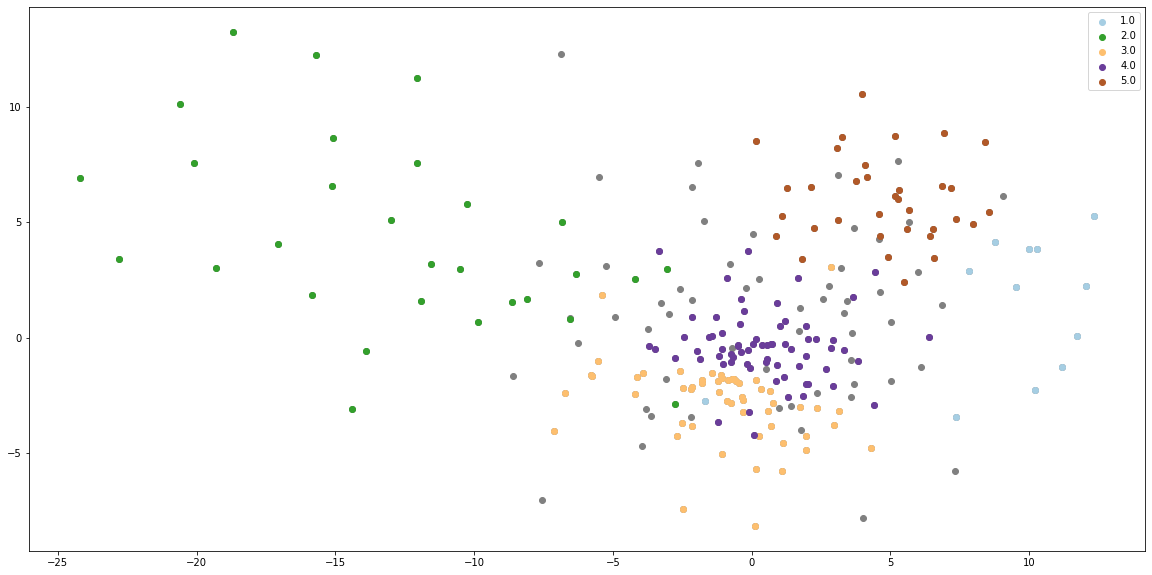

In [9]:
ae2.eval()
for data in test_cardiac_RNA_loader:
    ae_coordinates = ae2[:1](data['count']).detach().numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()


# data 3, oeHBC data, small one 
cell_type = cardiac_RNA.cluster.values
cluster_types = np.unique(cell_type)

colormap = plt.cm.get_cmap("Paired", 5)
ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = "gray", alpha = 1)
for i, cluster_type in enumerate(cluster_types):
    if not np.isnan(cluster_type):
        index = np.where(cell_type == cluster_type)[0]
        ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1, label = cluster_type)

ax.legend()

In [ ]:
train_model(model = ae3, 
            data_loader = train_cardiac_ATAC_loader, 
            diff_sim = Diff4, 
            n_epochs = 150)

In [ ]:
ae3.eval()
for data in test_cardiac_ATAC_loader:
    ae_coordinates = ae3[:1](data['count']).detach().numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()


# data 3, oeHBC data, small one 
cell_type = cardiac_ATAC.cluster.values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])
for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)

In [10]:
train_model(model = ae1, 
            data_loader = train_r1b1_loader, 
            diff_sim = Diff1, 
            n_epochs = 150)

train loss:  7.547685146331787 loss_recon: 8.505420684814453 loss_dist: -0.9577354192733765
train loss:  -0.3911983370780945 loss_recon: 0.5925865173339844 loss_dist: -0.9837848544120789
train loss:  -0.47749626636505127 loss_recon: 0.5112832188606262 loss_dist: -0.9887794852256775
train loss:  -0.4800635576248169 loss_recon: 0.5093300342559814 loss_dist: -0.9893935918807983
train loss:  -0.48893439769744873 loss_recon: 0.501440167427063 loss_dist: -0.9903745651245117
train loss:  -0.4998721778392792 loss_recon: 0.4899498522281647 loss_dist: -0.9898220300674438
train loss:  -0.49833160638809204 loss_recon: 0.4914449453353882 loss_dist: -0.9897765517234802
train loss:  -0.49963638186454773 loss_recon: 0.4915197193622589 loss_dist: -0.9911561012268066
train loss:  -0.49570411443710327 loss_recon: 0.4937778115272522 loss_dist: -0.9894819259643555
train loss:  -0.4880906939506531 loss_recon: 0.5007685422897339 loss_dist: -0.988859236240387
train loss:  -0.5076538920402527 loss_recon: 0.482

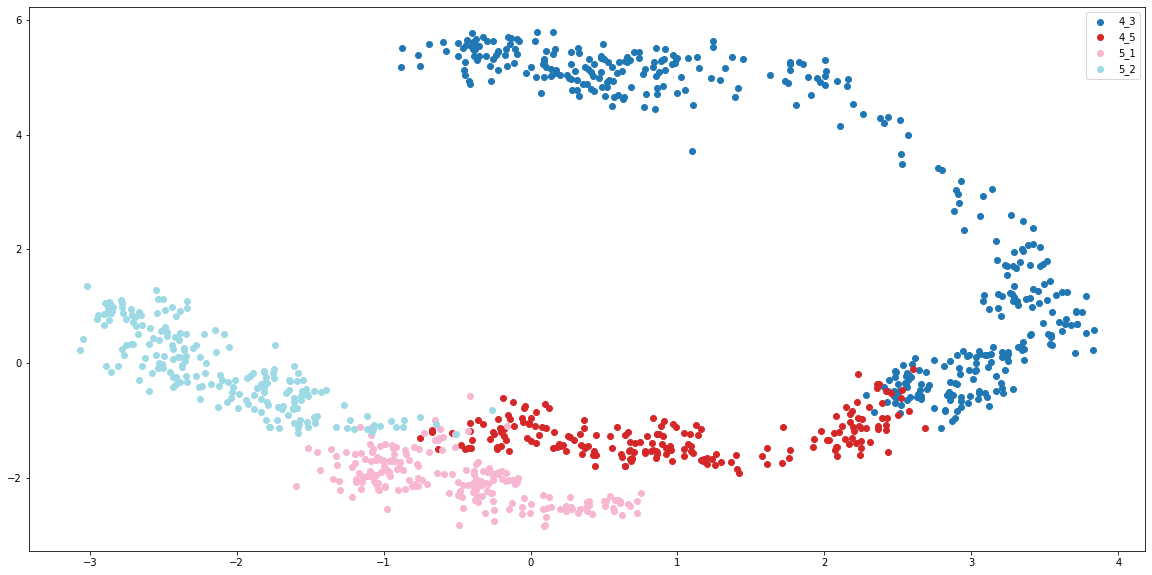

In [12]:
ae1.eval()
for data in test_r1b1_loader:
    ae_coordinates = ae1[:1](data['count']).detach().numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()


# data 3, oeHBC data, small one 
cell_type = symsim_r1b1.cell_labels["pop"].values
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])
for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)

In [11]:
# jointly
def train_joint(model1, model2, discriminator, train_loader1, train_loader2, diff_sim1, diff_sim2, n_iter = 10, n_epochs = 150):
    for it in range(n_iter):
        train_model(model = model1, 
                    data_loader = train_loader1, 
                    diff_sim = diff_sim1, 
                    n_epochs = n_epochs)

        train_model(model = model2, 
                    data_loader = train_loader2, 
                    diff_sim = diff_sim2, 
                    n_epochs = n_epochs)
    

## scATAC-Seq and scRNA-Seq

In [2]:
dataset = hhRNADataset(rna_seq_file="./data/human_hematopoiesis/scRNA_500gs.csv")
# dataset = test_paul()

In [4]:
train_loader = DataLoader(dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(dataset, batch_size = len(dataset))
expr_RNA = []
# cell_info = pd.read_csv("./data/Paul/Paul_cell_meta.txt", sep="\t")
# cell_type = cell_info['cell_type2']
cell_type = []
for data in test_loader:
    expr_RNA = data['RNA'].numpy()
    cell_type = np.array(data['cell_type'])

In [5]:
expr_RNA.shape

(2699, 500)

In [6]:
# diffu_RNA = diff.diffusion_map(expr_RNA, n_eign = None, alpha = 200, diffusion_time = 5)
# diff_sim = diff.diffusion_similarity(diffu_RNA)
# fig = plt.figure(figsize = (20,10))
# ax = fig.add_subplot()
# ax.scatter(diffu_RNA[:,2], diffu_RNA[:,3], c=np.arange(diffu_RNA.shape[0]))

# DPT distance
DPT_RNA = diff.DPT_similarity(expr_RNA, n_neigh = 10, log_trans=True)
# Phate distance
# Phate_RNA = diff.phate_similarity(expr_RNA, t = 5, use_potential = True)
# Diffmap distance
# Diffmap_RNA = diff.phate_similarity(expr_RNA, t = 5, use_potential = False)

DPT_tensor = torch.FloatTensor(DPT_RNA)
# Phate_tensor = torch.FloatTensor(Phate_RNA)
# Diffmap_tensor = torch.FloatTensor(Diffmap_RNA)

In [7]:
DPT_RNA

array([[0.        , 1.80655209, 0.83828535, ..., 0.45654382, 1.80344581,
        0.76167272],
       [1.80655209, 0.        , 1.94796673, ..., 1.75803471, 0.6332476 ,
        1.93178523],
       [0.83828535, 1.94796673, 0.        , ..., 0.93485259, 1.94451599,
        0.38455487],
       ...,
       [0.45654382, 1.75803471, 0.93485259, ..., 0.        , 1.75519157,
        0.86840489],
       [1.80344581, 0.6332476 , 1.94451599, ..., 1.75519157, 0.        ,
        1.92833293],
       [0.76167272, 1.93178523, 0.38455487, ..., 0.86840489, 1.92833293,
        0.        ]])

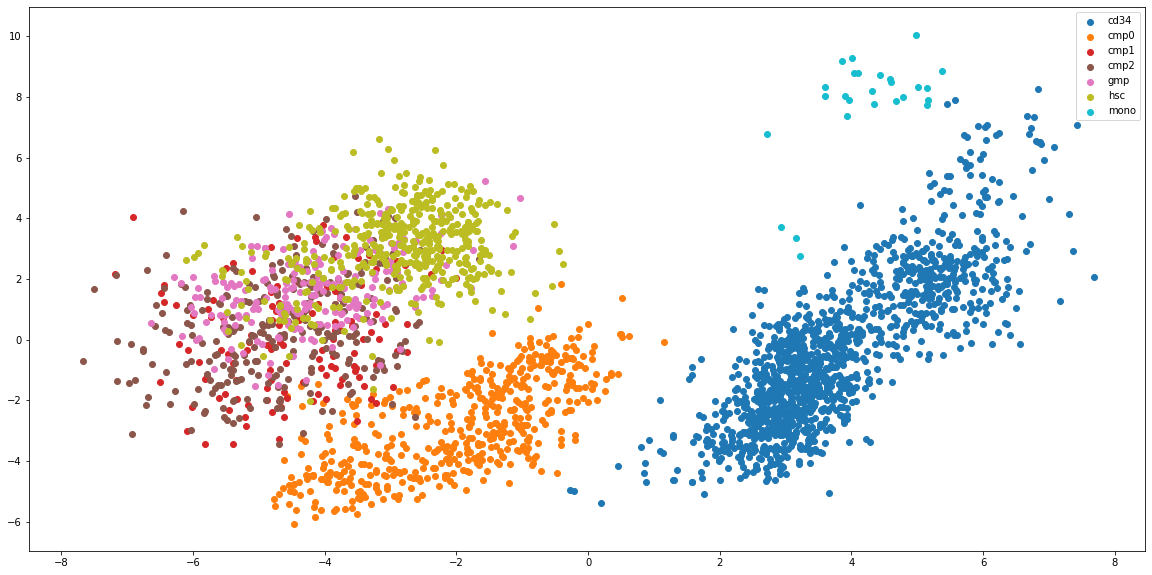

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_RNA = pca.fit_transform(expr_RNA)

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

# data 3, oeHBC data, small one
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab10", cluster_types.shape[0])
for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(pca_RNA[index,0], pca_RNA[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)

In [11]:
CONFIG = { 
    'in_features': expr_RNA.shape[1],
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
}


encoder = ae.Encoder(cfg = CONFIG)
decoder = ae.Decoder(cfg = CONFIG)
auto_encoder = nn.Sequential(encoder, decoder)

In [13]:
train_model(auto_encoder, train_loader, DPT_tensor, learning_rate = 1e-3, lamb_r = 1, lamb_d = 1)

train loss:  -0.7758851647377014 loss_recon: 0.20732425153255463 loss_dist: -0.9832094311714172
train loss:  -0.809124231338501 loss_recon: 0.1750560700893402 loss_dist: -0.9841803312301636
train loss:  -0.8322560787200928 loss_recon: 0.1656995564699173 loss_dist: -0.9979556202888489
train loss:  -0.8505851030349731 loss_recon: 0.1468549519777298 loss_dist: -0.9974400401115417
train loss:  -0.8720091581344604 loss_recon: 0.12375140935182571 loss_dist: -0.9957605600357056


## Real result

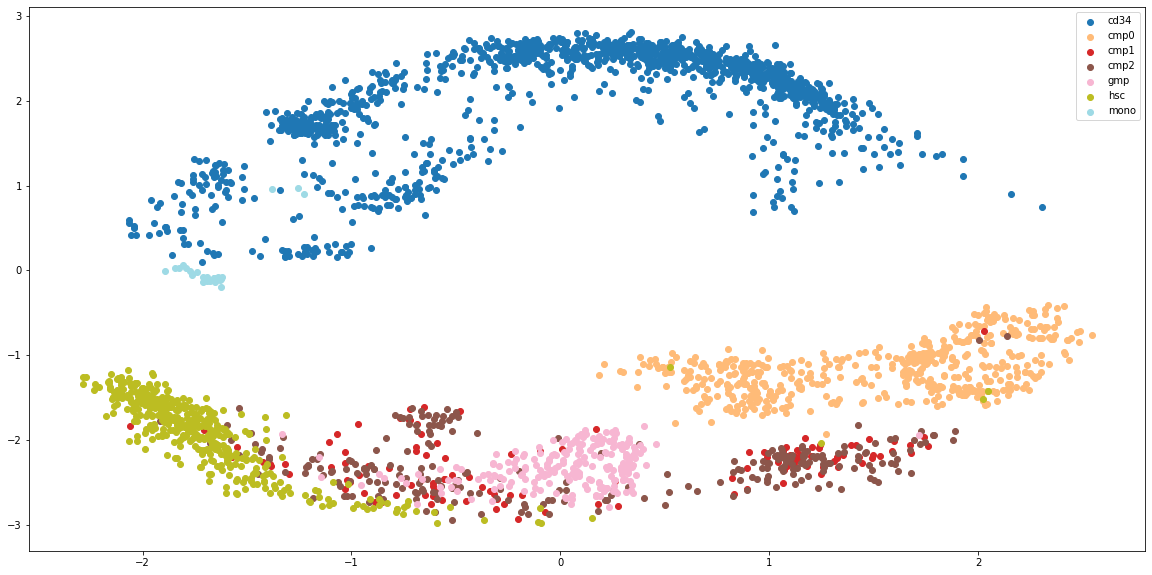

In [84]:
auto_encoder.eval()
for data in test_loader:
    ae_coordinates = auto_encoder[:1](data['RNA']).detach().numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

# data 3, oeHBC data, small one 
cell_type = np.array(cell_type)
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])
for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)

## Test dataset

In [5]:
# scurve_dataset = test_s_curve()
# expr_RNA = scurve_dataset[:]['RNA']
# # DPT distance
# DPT_RNA = diff.DPT_similarity(expr_RNA)
# # Phate distance
# Phate_RNA = diff.phate_similarity(expr_RNA, t = 5, use_potential = True)
# # Diffmap distance
# Diffmap_RNA = diff.phate_similarity(expr_RNA, t = 5, use_potential = False)

# DPT_tensor = torch.FloatTensor(DPT_RNA)
# Phate_tensor = torch.FloatTensor(Phate_RNA)
# Diffmap_tensor = torch.FloatTensor(Diffmap_RNA)

# fig = plt.figure(figsize = (20,10))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(X[:,0],X[:,1],X[:,2], c = color)

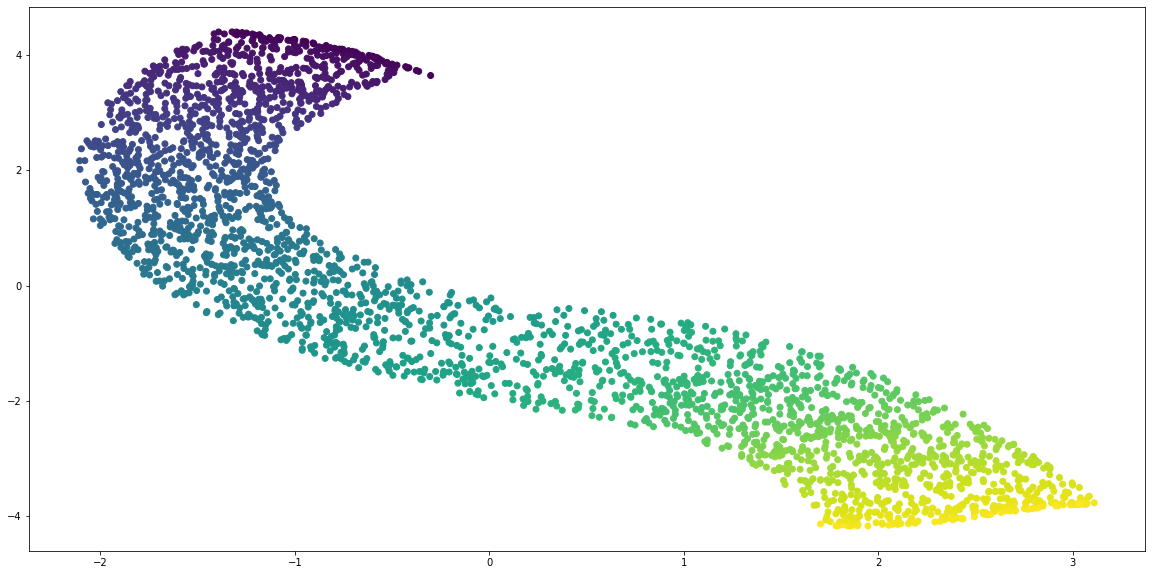

In [29]:
auto_encoder.eval()
for data in test_loader:
    ae_coordinates = auto_encoder[:1](data['RNA']).detach().numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

ax.scatter(ae_coordinates[:,0],ae_coordinates[:,1], c = color)

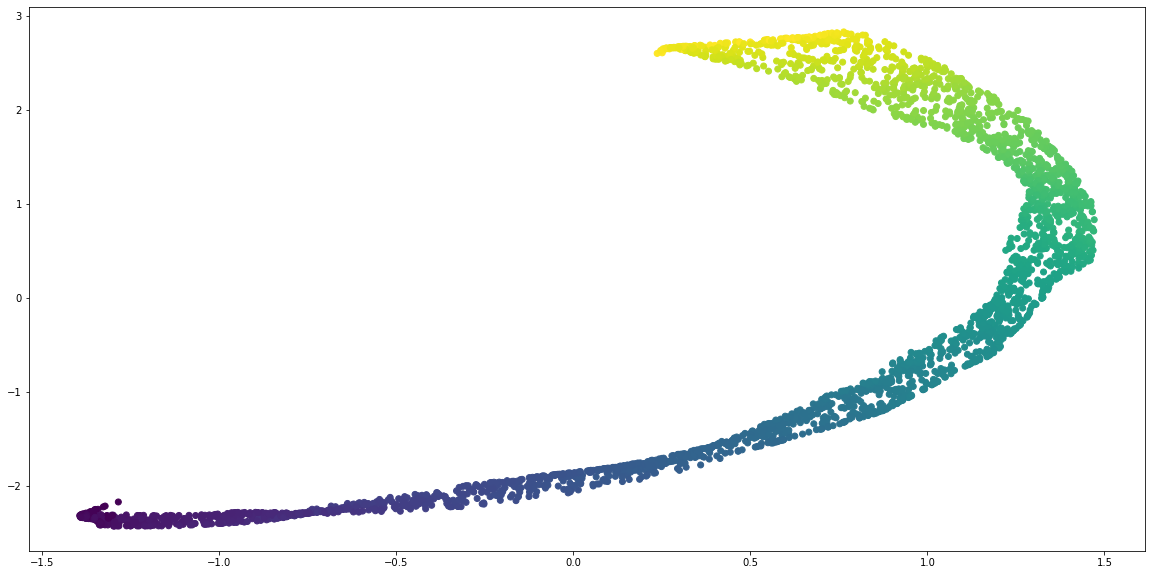

In [24]:
auto_encoder.eval()
for data in test_loader:
    ae_coordinates = auto_encoder[:1](data['RNA']).detach().numpy()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

ax.scatter(ae_coordinates[:,0],ae_coordinates[:,1], c = color)